This notebook is written by Mathias Rose Bjare (s113038@student.dtu.dk) and  answears Deep RL Assignment 1, http://rail.eecs.berkeley.edu/deeprlcourse/static/homeworks/hw1.pdf.
The code base for this file can be found at https://github.com/muthissar/homework.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

In [1]:
import pickle
import tensorflow as tf
import numpy as np
from behavioral_cloning import *
import matplotlib.pyplot as plt
import pandas as pd

## Inspect
show the shape of action and state

In [3]:
with open('./expert_data/Ant-v2.pkl', 'rb') as f:
    trace = pickle.load(f)
print('state shape {}'.format(trace['observations'].shape))
print('state example {}'.format(trace['observations'][0]))
print('actions shape {}'.format(trace['actions'].shape))
print('actions example {}'.format(trace['actions'][0]))

state shape (99286, 111)
state example [ 0.71573081  0.99940448  0.02172482  0.01214414 -0.02390038 -0.0665109
  0.01878657 -0.00400649  0.03484956  0.05231029  0.02381142 -0.04922052
  0.06561302  0.00577665 -0.16576287  0.0679862  -0.05062527  0.0702232
 -0.12525527 -0.03925672  0.00716105  0.04726429 -0.10090095 -0.05052721
  0.13599655  0.04025173 -0.04089372  0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.     

# Behavioral Cloning
The following fits an FNN with one hidden layer of 50 nodes each for the task 'Hopper-v2' and 'Ant-v2'. Dropout of 0.5 is used on both stages. The number of expert rollouts for the imitation learning is 20. This is done for multiple different training epochs. The results are evaluated through the training epochs on 20 rollouts.

In [8]:
batch_size = 32
expert_rollout = 20
max_timesteps = 0 #0 means run until termination
use_expert_cache = True
store=False
losses = []



#tasks = ['Hopper-v2', 'Ant-v2', 'HalfCheetah-v2',
#'Humanoid-v2', 'Reacher-v2','Walker2d-v2']
tasks = ['Hopper-v2','Ant-v2']
results = pd.DataFrame(columns=['Task','mean return','std return'])

for task in tasks:
    print("running task {}".format(task))
    tf.reset_default_graph()
    with tf.Session() as sess:
        epoch_count = 0
        # Repeats the data for the specified epochs
        repeats = [1,1,1,2,5,10,10,30] 
        if use_expert_cache:
            original_dataset, expert_returns = get_dataset(\
                './expert_data/{}-{}.pkl'.format(task,expert_rollout))
        else:
            original_dataset, expert_returns = get_dataset(\
                envname=task,render=False,\
                expert_policy_file='experts/'+task+'.pkl',\
                max_timesteps=0,num_rollouts=expert_rollout,store=store)
        obs_dim = original_dataset.output_shapes[0].as_list()
        action_dim = original_dataset.output_shapes[1].as_list()[1:]
        # FNN network
        behavioral_net = BehavioralCloningNet(obs_dim, action_dim, batch_size)
        # object used for interacting with gym environment
        evaluate = Evaluate(task,render=False)
        # step method to be run at each simulation state.
        evaluate.step = lambda obs: behavioral_net.predict([obs])
        sess.run(tf.global_variables_initializer())
        for repeat in repeats:
            epoch_count += repeat
            dataset = original_dataset.repeat(repeat)
            # Random sampling
            dataset = dataset.shuffle(10000)    
            batched_dataset = dataset.batch(batch_size)
            iterator = batched_dataset.make_one_shot_iterator()
            next_element = iterator.get_next()            
            losses = behavioral_net.train(next_element)

            # Evaluate the policy 
            returns = evaluate.evaluate(rollouts=expert_rollout)
            print("epoch count {}, mean return {}".format(\
                epoch_count,np.mean(returns)))
            results = results.append({'Task': task,
                                'mean return': np.mean(returns),
                                'std return': np.std(returns),
                                'expert mean return': np.mean(expert_returns),
                                'expert std return': np.std(expert_returns),
                                'expert rollouts': expert_rollout,
                                'training epochs': epoch_count},
                                ignore_index=True)
#subfig = plt.subplot()
#fig = plt.figure()
#plt.plot(losses)
#plt.xlabel('Batch')
#plt.ylabel('Loss (mean square)')
#plt.legend(['Train loss {}'.format(task)],loc='upper center')
#plt.show(fig)
results.to_csv('results_behavioral.csv')

running task Hopper-v2
epoch count 1, mean return 190.20921293122856
epoch count 2, mean return 164.85157444265056
epoch count 3, mean return 272.4991823314864
epoch count 5, mean return 667.7953018549435
epoch count 10, mean return 1603.544325283348
epoch count 20, mean return 1121.727173913639
epoch count 30, mean return 1130.3687859166273
epoch count 60, mean return 1277.464673881775
running task Ant-v2
epoch count 1, mean return 952.1392498418054
epoch count 2, mean return 1626.5571830820334
epoch count 3, mean return 2402.2324505545816
epoch count 5, mean return 3941.9624484160195
epoch count 10, mean return 4442.969743863994
epoch count 20, mean return 4774.831564098394
epoch count 30, mean return 4801.477685153428
epoch count 60, mean return 4635.262110394464


Possibly run from cached results

In [2]:
results = pd.read_csv('results_behavioral.csv')

In [3]:
results.drop(['expert rollouts'],axis=1)

,Unnamed: 0,Task,mean return,std return,expert mean return,expert std return,training epochs
0,0,Hopper-v2,190.209213,1.294158,3777.774247,3.781346,1.0
1,1,Hopper-v2,164.851574,1.245350,3777.774247,3.781346,2.0
2,2,Hopper-v2,272.499182,3.423025,3777.774247,3.781346,3.0
3,3,Hopper-v2,667.795302,4.225686,3777.774247,3.781346,5.0
4,4,Hopper-v2,1603.544325,401.461250,3777.774247,3.781346,10.0
5,5,Hopper-v2,1121.727174,108.054448,3777.774247,3.781346,20.0
6,6,Hopper-v2,1130.368786,46.614576,3777.774247,3.781346,30.0
7,7,Hopper-v2,1277.464674,202.356706,3777.774247,3.781346,60.0
8,8,Ant-v2,952.139250,157.326344,4791.193292,156.043874,1.0
9,9,Ant-v2,1626.557183,181.050082,4791.193292,156.043874,2.0


## 'Ant-v2'
The table shows that using only a few epochs we are able to perform as well as the expert.

## 'Hopper-v2'
For the hopper task, we are unable to perform as good as the expert, even when the number of training epochs are increased.

This is illustrated in the figure below, where the return is plotted agains the training iterations.
The mean of the expert on 20 training epochs are also plotted.

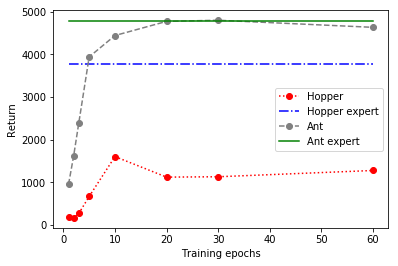

In [4]:
fig = plt.figure()
hopper_data = results[results['Task']=='Hopper-v2']
ant_data = results[results['Task']=='Ant-v2']
epochs = ant_data['training epochs'].values
plt.plot(epochs,hopper_data['mean return'].values,'-o',c='red',linestyle=':')
plt.plot(epochs,hopper_data['expert mean return'].values,c='blue',linestyle="-.")
plt.plot(epochs,ant_data['mean return'].values,'-o',c='grey',linestyle="--")
plt.plot(epochs,ant_data['expert mean return'].values,c='green',linestyle="-")
plt.legend(['Hopper','Hopper expert','Ant','Ant expert'])
plt.xlabel('Training epochs')
plt.ylabel('Return')
plt.show(fig)